In [423]:
import time
import os


import numpy as np
import pandas as pd

import datetime as dt


from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc,roc_auc_score
from sklearn import neighbors

In [424]:
models = {
            'linear' : {
                    'mod' : LogisticRegression(solver = 'saga'),
                    'par' : {'penalty' : ('l1','l2','elasticnet','none'),
                                'C': [1,1.5,2],
                            'l1_ratio':[0.2,0.5,0.8]}
                    },                     
            'gradient' : {
                    'mod' : GradientBoostingClassifier(warm_start = True),
                    'par' : {'loss' : ('deviance', 'exponential'),
                             'max_depth' : [3, 4, 5, 6, 7]}
                        },
           'tree':{'mod': DecisionTreeClassifier(),
                     'par':{'splitter':('best','random'),
                            'max_depth': [None, 2,4,6],
                            'min_samples_leaf':[1,5,8]}},
            'svm' : {
                    'mod' : svm.SVC(probability=True),
                    'par' : {'kernel' : ( 'linear', 'rbf')}
                    },
        'RandomForest' : {
                    'mod' : RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4, criterion = 'gini'),
                    'par' : {'max_depth' :[None, 2,4,6],
                            'min_samples_leaf':[1,5,8]}
                        },
        'Knn' : {
                    'mod' : neighbors.KNeighborsClassifier(),
                    'par' : {'n_neighbors' :[5, 10, 15],
                            'leaf_size':[15,25,30]}
                        }
    
        }


In [425]:
def grid(x_name,n_proc, os_X_tt, os_Y_tt, models, score = 'roc_auc', cv = 5):
    # Gridsearch
    bestmodels = models.copy()
    for name in models:
        print('*'*80)
        print("Model: " + name)
        t_beg = time.time()

        pipeline = Pipeline([('scaler', StandardScaler()), (name,  bestmodels[name]['mod'])])          
        parameters = {}          
        for par in bestmodels[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = bestmodels[name]['par'][par]    
        aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc,\
                          scoring = score, verbose=2, cv = cv)
        aux.fit(os_X_tt, os_Y_tt)
        bestmodels[name]['bestModel'] = aux.best_estimator_
        bestmodels[name][score] = aux.best_score_
        bestmodels[name]['cols_order'] = os_X_tt.columns.values
        selection_time = time.time() - t_beg

        bestmodels[name]['selection_time'] = selection_time

        sample_f_path = f'modelos/{x_name}' + f'{name}_{dt.datetime.now().strftime("%Y%m%d-%H%M")}.sav'

        print(f"Saving model at {sample_f_path}")    
        joblib.dump(bestmodels[name]['bestModel'], sample_f_path)

        print(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        print(f"El error {score} de la familia {name} es: {bestmodels[name][score]:0.3f}")
        print('*'*80)
       
    mod_name = None
    best_mae = -np.inf
    for name in models:
        if bestmodels[name][score] > best_mae:
            mod_name = name
            best_mae = bestmodels[name][score]

    print(f"best model: " + mod_name + f" with an error {score} of: " + str(best_mae))
    
    return bestmodels

# 1. Lectura de los datos

In [426]:
path = 'databinarystudents.csv'
data = pd.read_csv(path, sep = ',', na_filter = False)
data = data.set_index('id')

In [427]:
# variables seleccionadas según diferentes criterios
y = data[['yL']].copy()
X = data.drop(columns = ['yL']).copy()

In [428]:
# Definición del tamaño del test
test_size = 0.3

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [430]:
# variables con probabilidad de selección mayor al 55%
X1_train= X_train[['x1','x2','x3','x4','x10','x11','x12','x14','x17','x18','x21','x22','x23','x24','x25','x27','x30','x32']].copy()
X1_test = X_test[['x1','x2','x3','x4','x10','x11','x12','x14','x17','x18','x21','x22','x23','x24','x25','x27','x30','x32']].copy()

# variables con probabilidad de selección mayor al 60%
X2_train= X_train[['x1','x2','x3','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()
X2_test= X_test[['x1','x2','x3','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()

# variables con probabilidad de selección mayor al 65%
X3_train= X_train[['x1','x2','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()
X3_test= X_test[['x1','x2','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()

# variables con probabilidad de selección mayor al 70%
X4_train= X_train[['x1','x2','x4','x10','x11','x12','x17','x23']].copy()
X4_test= X_test[['x1','x2','x4','x10','x11','x12','x17','x23']].copy()

# variables con probabilidad de selección mayor al 80%
X5_train= X_train[['x1','x10','x12','x17','x23']].copy()
X5_test= X_test[['x1','x10','x12','x17','x23']].copy()

In [431]:
Bestmodels_X1  = grid('X1', 3, X1_train, y_train.values, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    1.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Convergence

Saving model at modelos/X1linear_20190908-1817.sav
El tiempo de seleccion fue: 1.236 s
El error roc_auc de la familia linear es: 0.675
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X1gradient_20190908-1817.sav
El tiempo de seleccion fue: 1.097 s
El error roc_auc de la familia gradient es: 0.648
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-ve

Saving model at modelos/X1tree_20190908-1817.sav
El tiempo de seleccion fue: 0.413 s
El error roc_auc de la familia tree es: 0.702
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X1svm_20190908-1817.sav
El tiempo de seleccion fue: 0.079 s
El error roc_auc de la familia svm es: 0.665
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    2.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X1RandomForest_20190908-1817.sav
El tiempo de seleccion fue: 2.270 s
El error roc_auc de la familia RandomForest es: 0.705
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X1Knn_20190908-1817.sav
El tiempo de seleccion fue: 0.377 s
El error roc_auc de la familia Knn es: 0.737
********************************************************************************
best model: Knn with an error roc_auc of: 0.7373430141287283


[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


<IPython.core.display.Javascript object>


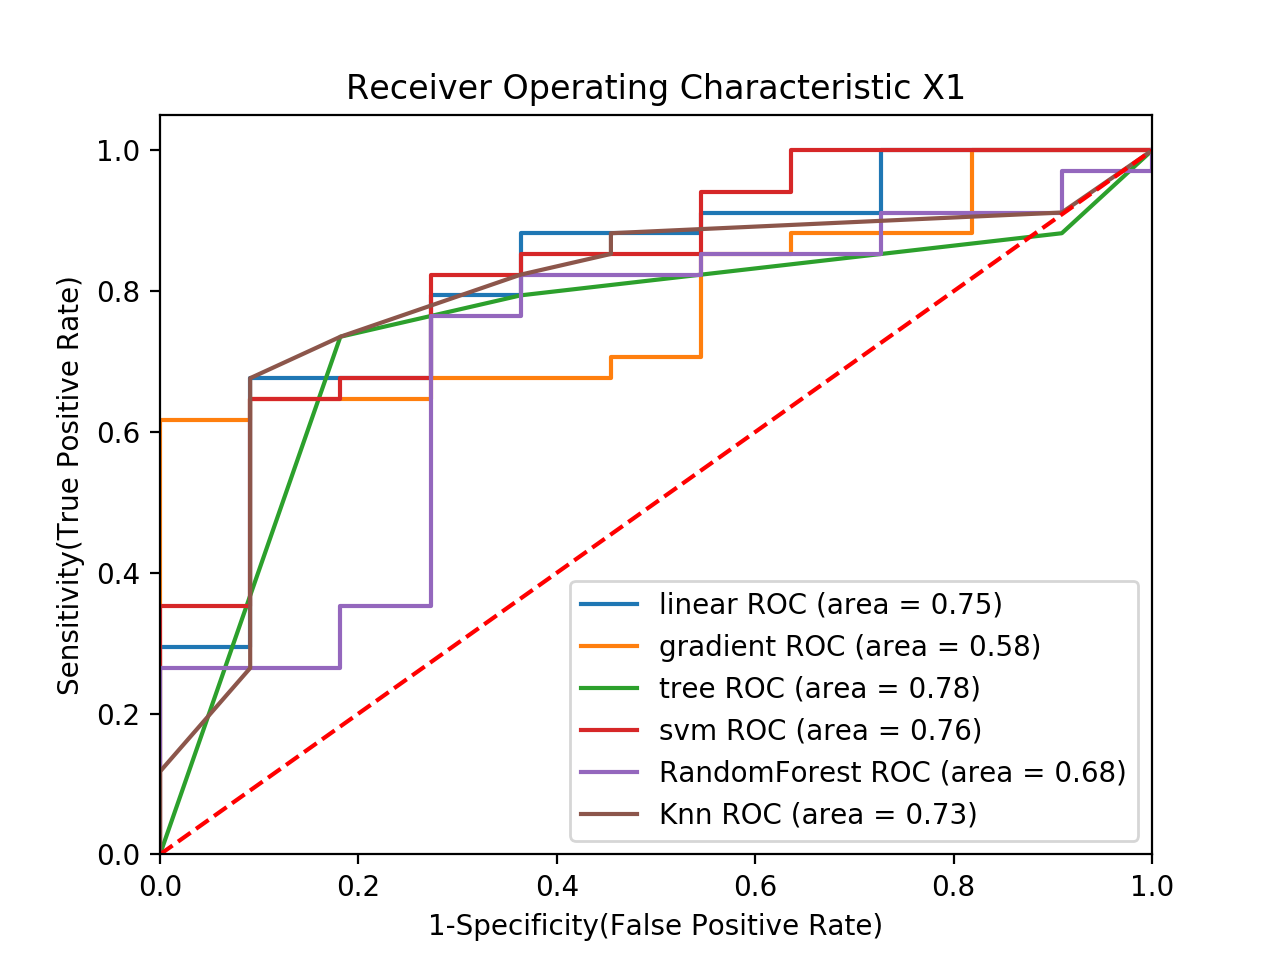

In [432]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X1:
    model =Bestmodels_X1[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X1_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X1_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X1')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X1.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [433]:
Bestmodels_X2  = grid('X2',3, X2_train, y_train.values, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Convergence

Saving model at modelos/X2linear_20190908-1817.sav
El tiempo de seleccion fue: 1.056 s
El error roc_auc de la familia linear es: 0.731
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X2gradient_20190908-1817.sav
El tiempo de seleccion fue: 1.120 s
El error roc_auc de la familia gradient es: 0.649
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-ve

Saving model at modelos/X2tree_20190908-1817.sav
El tiempo de seleccion fue: 0.382 s
El error roc_auc de la familia tree es: 0.711
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X2svm_20190908-1817.sav
El tiempo de seleccion fue: 0.059 s
El error roc_auc de la familia svm es: 0.724
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    2.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X2RandomForest_20190908-1817.sav
El tiempo de seleccion fue: 2.241 s
El error roc_auc de la familia RandomForest es: 0.759
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X2Knn_20190908-1817.sav
El tiempo de seleccion fue: 0.382 s
El error roc_auc de la familia Knn es: 0.792
********************************************************************************
best model: Knn with an error roc_auc of: 0.7918956043956044


[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [434]:
coef_beta = Bestmodels_X2['linear']['bestModel'].named_steps.linear.coef_.tolist()
var_X2 = Bestmodels_X2['linear']['cols_order'].tolist()

In [435]:
coef_beta[0][0]

0.37394416491463317

In [436]:
for i in range(len(var_X2)):
    print(var_X2[i] +': '+ str(coef_beta[0][i]))

x1: 0.37394416491463317
x2: 0.09310271575330913
x3: -0.36893320744411834
x4: -0.6059147751338022
x10: 0.43614278508459436
x11: 0.4997192116344913
x12: -0.2336780909946412
x17: -0.23517711633023677
x21: 0.20028939112328192
x23: 0.9992932616188851
x25: -0.2303738257084582
x27: 0.25463662692589656


<IPython.core.display.Javascript object>


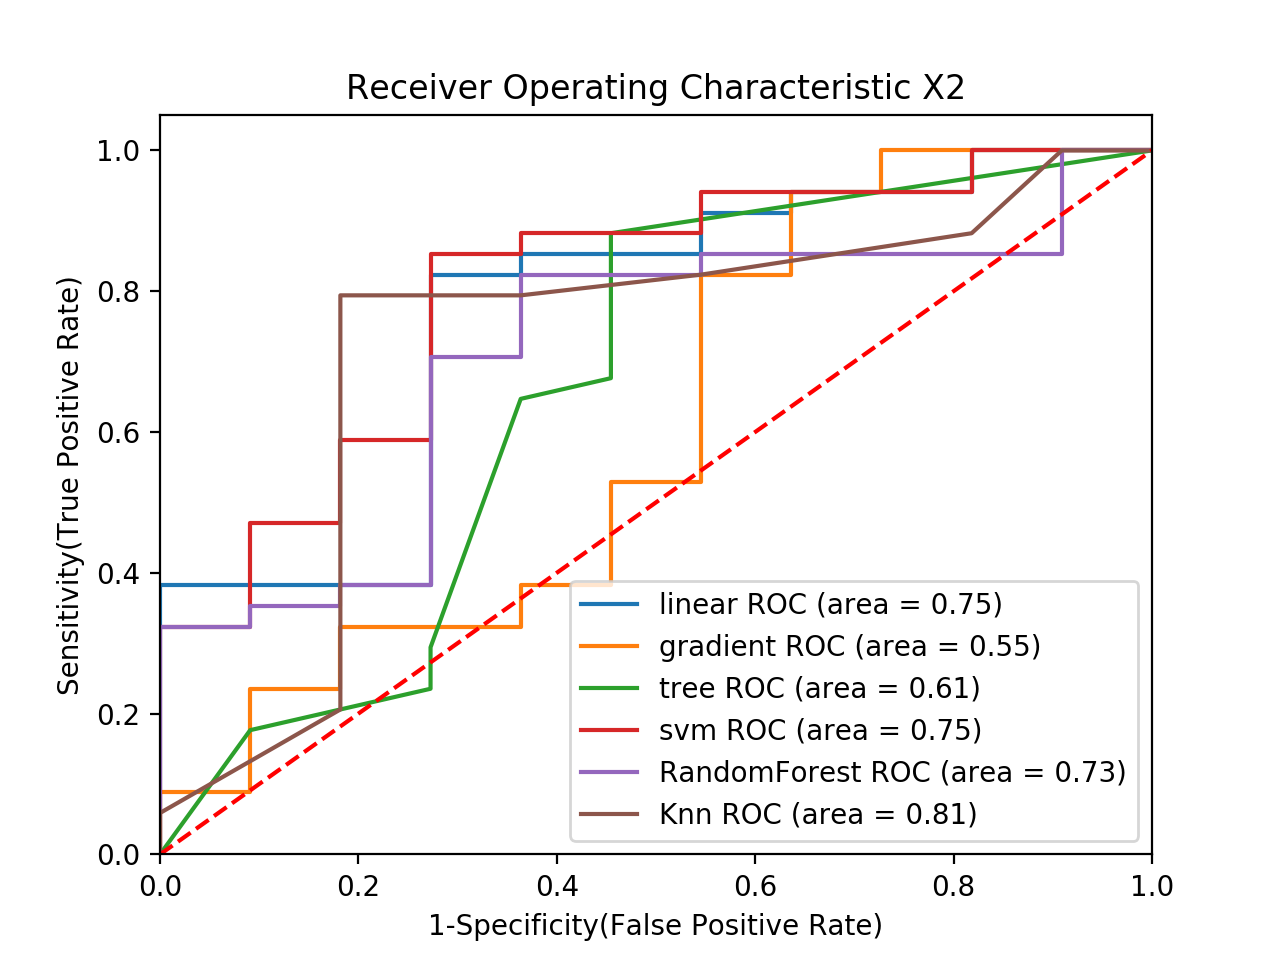

In [437]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X2:
    model =Bestmodels_X2[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X2_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X2_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X2')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X2.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [443]:
Bestmodels_X3  = grid('X3',3, X3_train, y_train.values, models, score = 'roc_auc', cv = 5)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    1.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X3linear_20190908-1818.sav
El tiempo de seleccion fue: 1.099 s
El error roc_auc de la familia linear es: 0.701
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X3gradient_20190908-1818.sav
El tiempo de seleccion fue: 1.180 s
El error roc_auc de la familia gradient es: 0.649
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-ve

Saving model at modelos/X3tree_20190908-1818.sav
El tiempo de seleccion fue: 0.413 s
El error roc_auc de la familia tree es: 0.743
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X3svm_20190908-1818.sav
El tiempo de seleccion fue: 0.088 s
El error roc_auc de la familia svm es: 0.692
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    2.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X3RandomForest_20190908-1818.sav
El tiempo de seleccion fue: 2.295 s
El error roc_auc de la familia RandomForest es: 0.734
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X3Knn_20190908-1818.sav
El tiempo de seleccion fue: 0.414 s
El error roc_auc de la familia Knn es: 0.749
********************************************************************************
best model: Knn with an error roc_auc of: 0.7493328100470957


[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


<IPython.core.display.Javascript object>


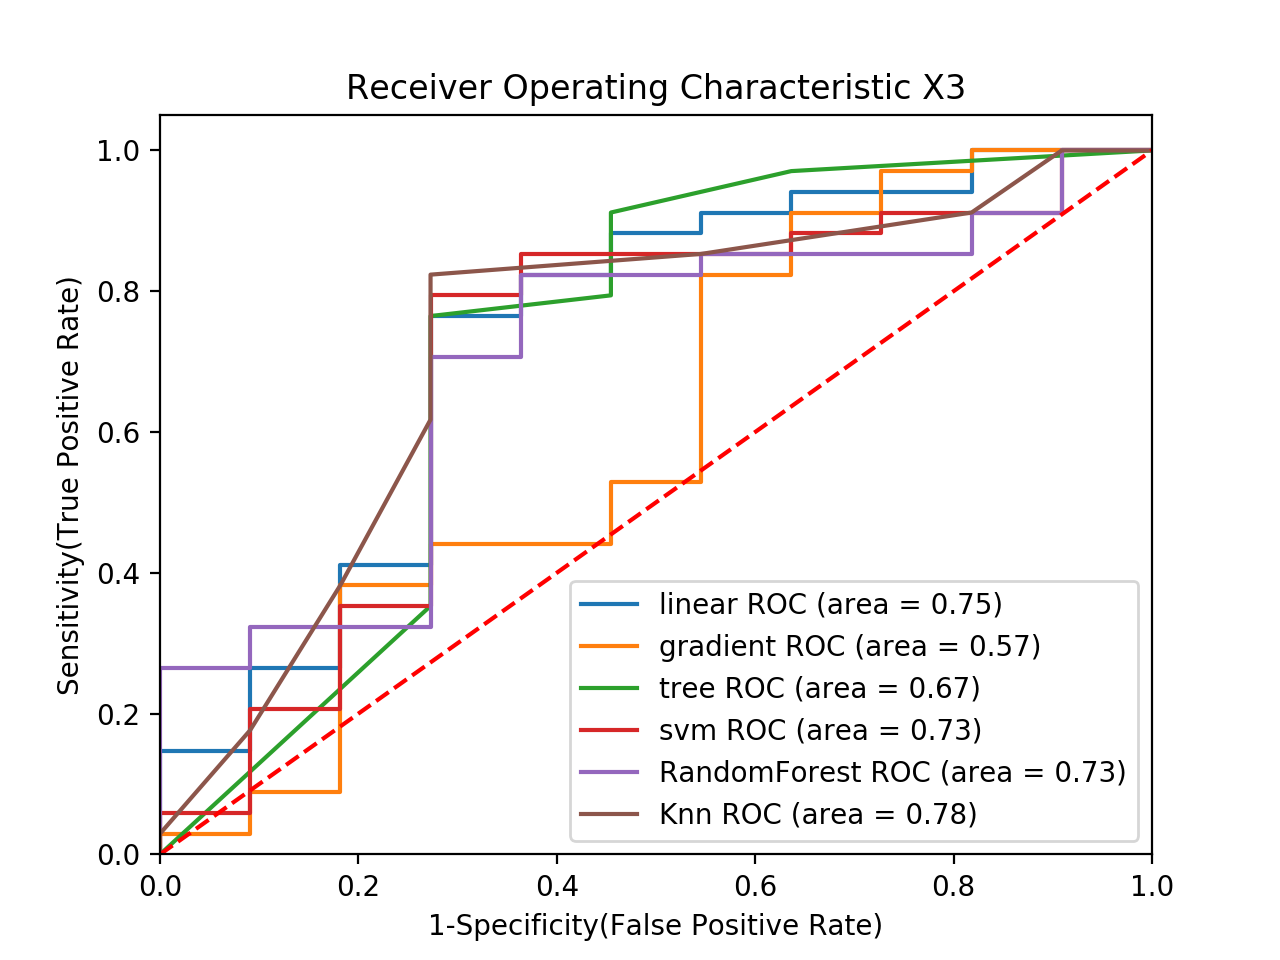

In [444]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X3:
    model =Bestmodels_X3[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X3_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X3_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X3')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X3.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [445]:
Bestmodels_X4  = grid('X4',3, X4_train, y_train.values, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    1.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: Convergence

Saving model at modelos/X4linear_20190908-1818.sav
El tiempo de seleccion fue: 1.102 s
El error roc_auc de la familia linear es: 0.711
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X4gradient_20190908-1818.sav
El tiempo de seleccion fue: 1.051 s
El error roc_auc de la familia gradient es: 0.723
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-ve

Saving model at modelos/X4tree_20190908-1818.sav
El tiempo de seleccion fue: 0.370 s
El error roc_auc de la familia tree es: 0.727
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X4svm_20190908-1818.sav
El tiempo de seleccion fue: 0.067 s
El error roc_auc de la familia svm es: 0.684
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    2.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X4RandomForest_20190908-1818.sav
El tiempo de seleccion fue: 2.330 s
El error roc_auc de la familia RandomForest es: 0.745
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X4Knn_20190908-1818.sav
El tiempo de seleccion fue: 0.396 s
El error roc_auc de la familia Knn es: 0.752
********************************************************************************
best model: Knn with an error roc_auc of: 0.7516352694924123


[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


<IPython.core.display.Javascript object>


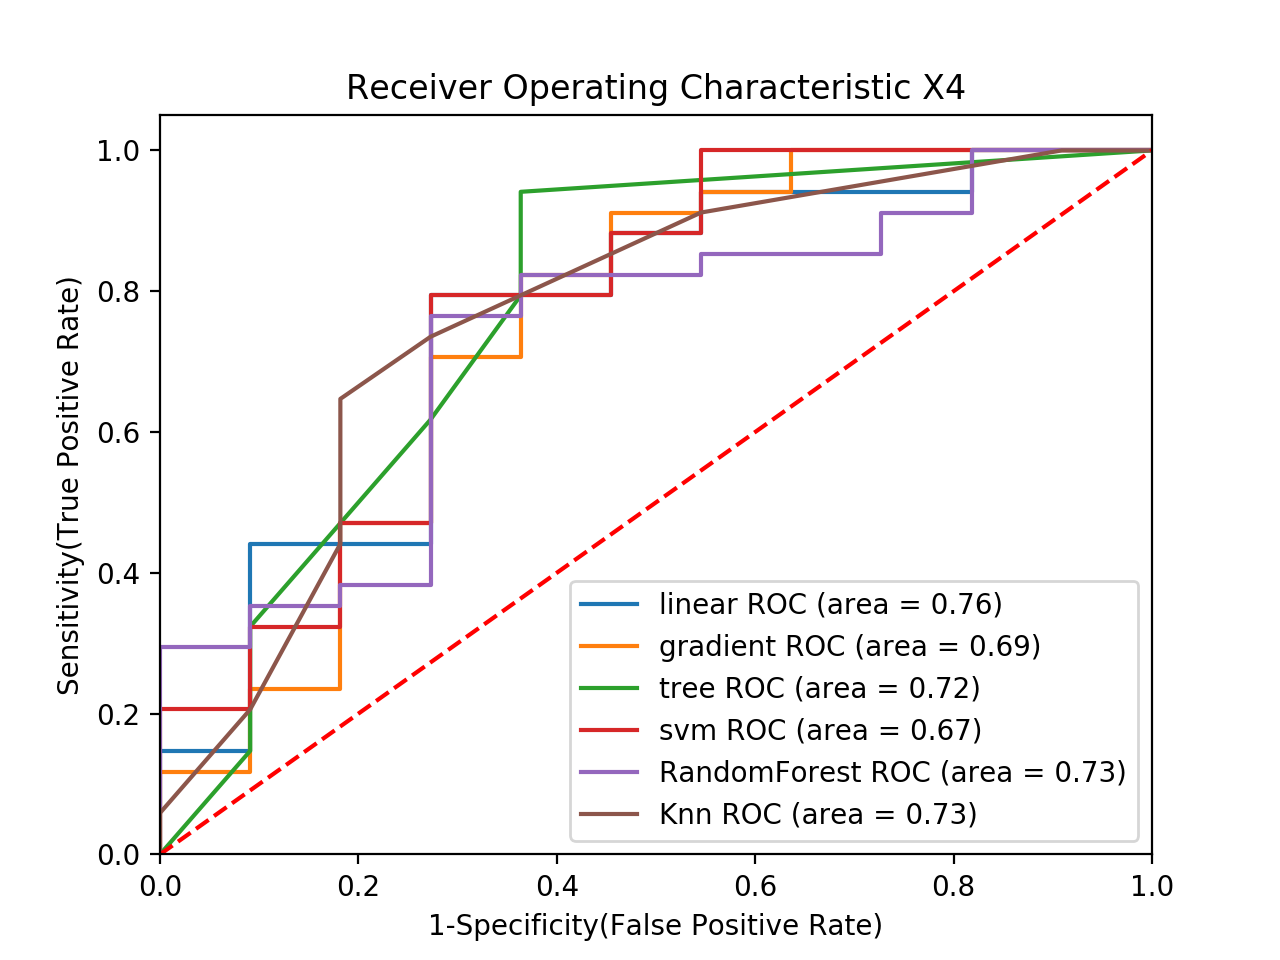

In [446]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X4:
    model =Bestmodels_X4[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X4_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X4_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X4')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X4.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [447]:
Bestmodels_X5  = grid('X4',3, X5_train, y_train.values, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X4linear_20190908-1818.sav
El tiempo de seleccion fue: 0.983 s
El error roc_auc de la familia linear es: 0.727
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    1.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X4gradient_20190908-1818.sav
El tiempo de seleccion fue: 1.138 s
El error roc_auc de la familia gradient es: 0.704
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-ve

Saving model at modelos/X4tree_20190908-1818.sav
El tiempo de seleccion fue: 0.415 s
El error roc_auc de la familia tree es: 0.700
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X4svm_20190908-1818.sav
El tiempo de seleccion fue: 0.056 s
El error roc_auc de la familia svm es: 0.688
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    2.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Saving model at modelos/X4RandomForest_20190908-1818.sav
El tiempo de seleccion fue: 2.357 s
El error roc_auc de la familia RandomForest es: 0.733
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X4Knn_20190908-1818.sav
El tiempo de seleccion fue: 0.414 s
El error roc_auc de la familia Knn es: 0.739
********************************************************************************
best model: Knn with an error roc_auc of: 0.7389259549973837


[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:    0.4s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


<IPython.core.display.Javascript object>


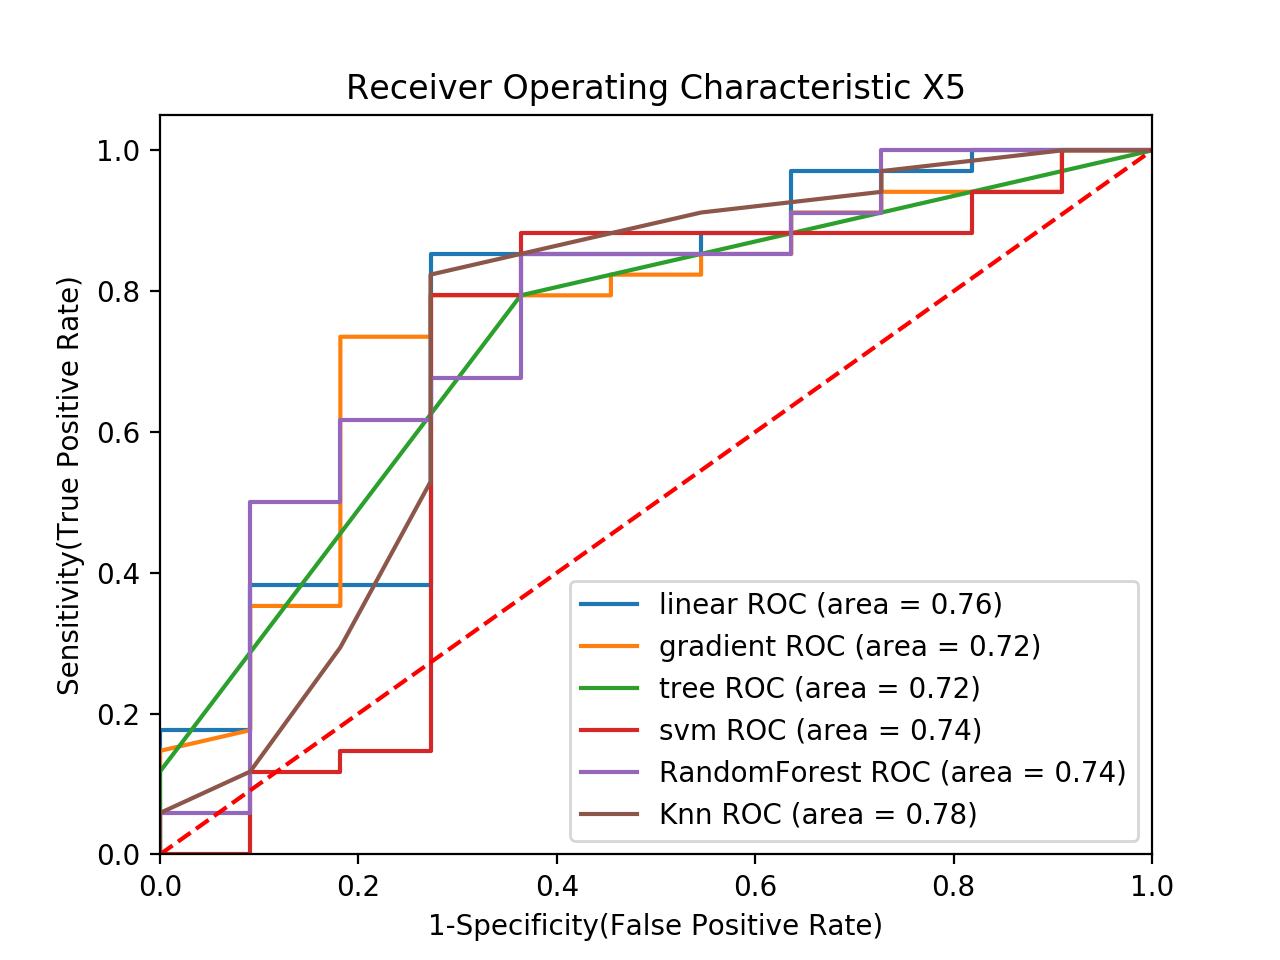

In [449]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X5:
    model =Bestmodels_X5[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X5_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X5_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X5')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X5.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [61]:
coef_beta = Bestmodels_X5['linear']['bestModel'].named_steps.linear.coef_.tolist()
var_X5 = Bestmodels_X5['linear']['cols_order'].tolist()
for i in range(len(var_X5)):
    print(var_X5[i] +': '+ str(coef_beta[0][i]))

x8: -0.1991208039604576
x10: 0.9875822179962412
x15: -0.02690200158252358
x17: -1.0598745351895424
x18: -0.6711168597910248
x22: 0.03757866185484855
x31: -0.16419925194523957


<IPython.core.display.Javascript object>


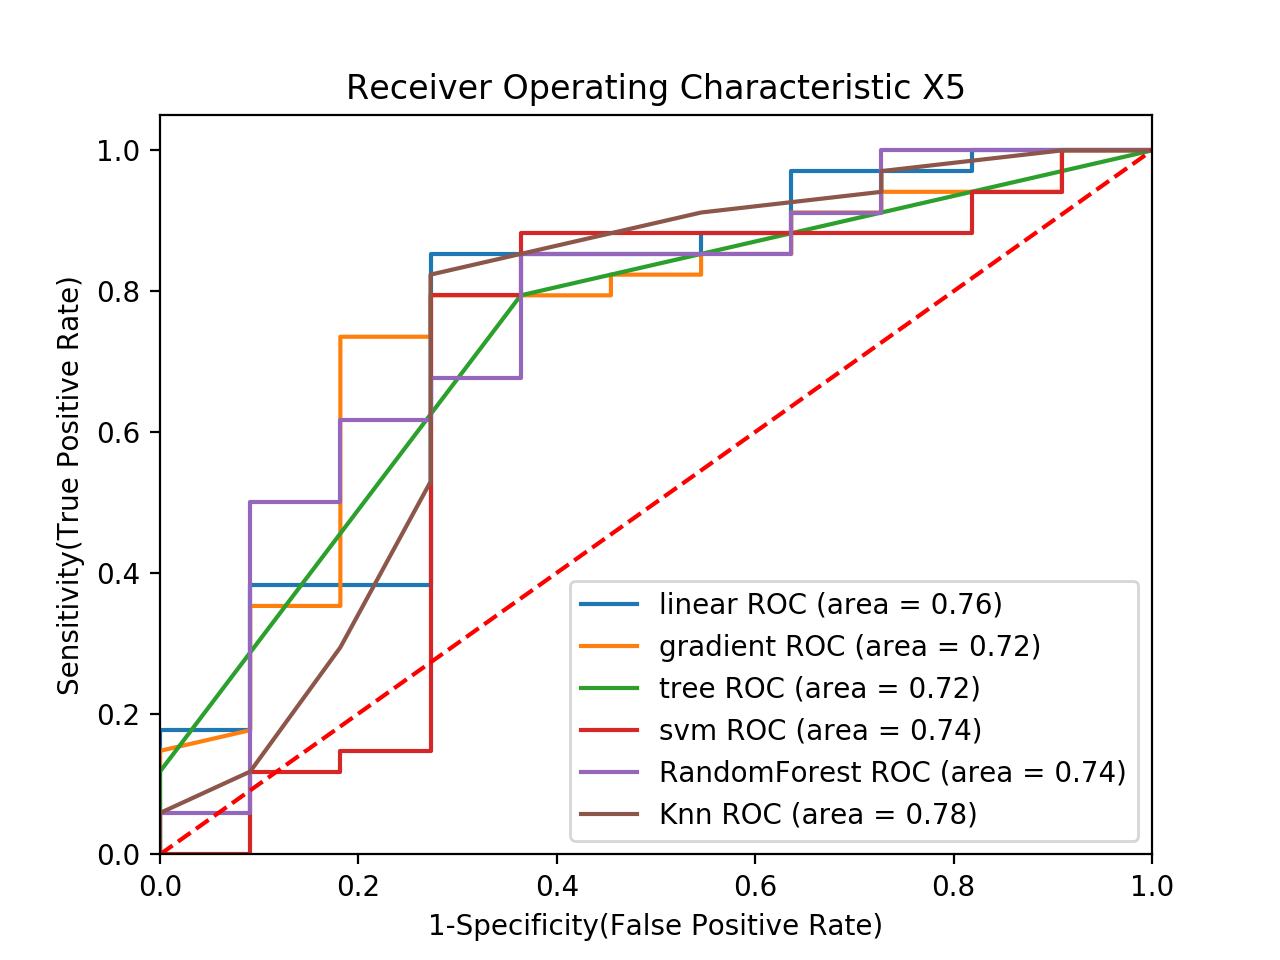

In [452]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X5:
    model =Bestmodels_X5[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X5_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X5_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X5')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X5.png', facecolor=fig.get_facecolor(), bbox_inches='tight')